## Advanced Seminar for Recognition System
##### Masashi Nakayama - Fall Semester 2025/26
### Jan Niklas Kappey (ID: 2568017)


**Create a linearly indistinguishable multi-class classification
system using a multi-layer perceptron. Please present your
findings, including any ingenuity you have used.**

In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)
print(os.listdir(path))

2026-01-21 01:38:20.287164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-21 01:38:20.510914: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-21 01:38:20.717414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768927100.883665    7860 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768927100.934674    7860 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768927101.331258    7860 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Path to dataset files: /home/nikla/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2
['rps-cv-images', 'scissors', 'rock', 'README_rpc-cv-images.txt', 'paper']


In [2]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices("GPU"))

GPUs: []


2026-01-21 01:38:28.303560: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
labels = ['paper','scissors','rock']

In [10]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
class CNN(Model):
    def __init__(self, hidden_dim=512, output_dim=3):
        super().__init__()
        self.l1 = Conv2D(32, (3, 3), activation='relu')
        self.l2 = MaxPooling2D((2, 2))
        self.l3 = Conv2D(32, (3, 3), activation='relu')
        self.l4 = MaxPooling2D((2, 2))
        self.l5 = Flatten()
        self.l6 = Dense(hidden_dim, activation='relu')
        self.l7 = Dense(output_dim, activation='softmax')

        # Define the layer sequence you intended to iterate through
        self.ls = [self.l1, self.l2, self.l3, self.l4, self.l5, self.l6, self.l7]

    def call(self, x, training=False):
        for layer in self.ls:
            x = layer(x)
        return x


In [15]:
def input_target_split(root_dir, labels, image_size=(150, 150)):
    dataset = []
    for class_id, label in enumerate(labels):
        folder = os.path.join(root_dir, label)
        if not os.path.isdir(folder):
            raise FileNotFoundError(
                f"Couldn't find folder: {folder}\n"
                f"Check your dataset path. Top-level contents: {os.listdir(root_dir)}"
            )

        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            img = load_img(fpath, target_size=image_size)
            img = img_to_array(img).astype("float32") / 255.0
            dataset.append((img, class_id))

    X, y = zip(*dataset)
    return np.array(X, dtype="float32"), np.array(y, dtype="int32")

In [16]:
X, y = input_target_split(path,labels)

In [17]:
test_size = 0.2

x_train, x_test, t_train, t_test= train_test_split(
    X, y, test_size=test_size, random_state=1234)

In [18]:
n = len(labels)
model = CNN(hidden_dim=12, output_dim=n)

# IMPORTANT: use sparse loss/acc since labels are integers
criterion = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.SGD(learning_rate=0.01)

train_loss = metrics.Mean(name="train_loss")
train_acc = metrics.SparseCategoricalAccuracy(name="train_acc")

In [19]:
def compute_loss(t, y):
    return criterion(t, y)

@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss = criterion(t, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss.update_state(loss)
    train_acc.update_state(t, preds)
    return loss

@tf.function
def test_step(x, t):
    preds = model(x, training=False)
    loss = criterion(t, preds)
    test_loss.update_state(loss)
    test_acc.update_state(t, preds)
    return loss


In [ ]:
epochs = 60
batch_size = 20
n_batches = x_train.shape[0] // batch_size

loss_history = []
acc_history = []

for epoch in range(epochs):
    # reset metrics EACH epoch (otherwise they accumulate across epochs)
    train_loss.reset_state()
    train_acc.reset_state()

    x_, t_ = shuffle(x_train, t_train, random_state=epoch)

    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_[start:end], t_[start:end])
        
    loss_history.append(train_loss.result().numpy())
    acc_history.append(train_acc.result().numpy())

    print(f"epoch: {epoch+1}, loss: {train_loss.result():.3f}, acc: {train_acc.result():.3f}")

epoch: 1, loss: 1.096, acc: 0.375
epoch: 2, loss: 1.011, acc: 0.468
epoch: 3, loss: 0.833, acc: 0.593
epoch: 4, loss: 0.772, acc: 0.607
epoch: 5, loss: 0.742, acc: 0.622
epoch: 6, loss: 0.727, acc: 0.619
epoch: 7, loss: 0.711, acc: 0.631
epoch: 8, loss: 0.706, acc: 0.630
epoch: 9, loss: 0.668, acc: 0.641
epoch: 10, loss: 0.620, acc: 0.703
epoch: 11, loss: 0.563, acc: 0.814
epoch: 12, loss: 0.525, acc: 0.817
epoch: 13, loss: 0.498, acc: 0.829
epoch: 14, loss: 0.483, acc: 0.835
epoch: 15, loss: 0.466, acc: 0.843
epoch: 16, loss: 0.456, acc: 0.846
epoch: 17, loss: 0.446, acc: 0.845
epoch: 18, loss: 0.425, acc: 0.864
epoch: 19, loss: 0.413, acc: 0.859
epoch: 20, loss: 0.409, acc: 0.866
epoch: 21, loss: 0.404, acc: 0.863
epoch: 22, loss: 0.388, acc: 0.874
epoch: 23, loss: 0.374, acc: 0.886
epoch: 24, loss: 0.373, acc: 0.879
epoch: 25, loss: 0.367, acc: 0.882
epoch: 26, loss: 0.361, acc: 0.880
epoch: 27, loss: 0.347, acc: 0.885
epoch: 28, loss: 0.338, acc: 0.895
epoch: 29, loss: 0.337, acc: 

In [21]:
test_loss = metrics.Mean(name="test_loss")
test_acc = metrics.SparseCategoricalAccuracy(name="test_acc")


test_step(x_test, t_test)

print(f"test_loss: {test_loss.result():.3f}, test_acc: {test_acc.result():.3f}")

test_loss: 0.269, test_acc: 0.925


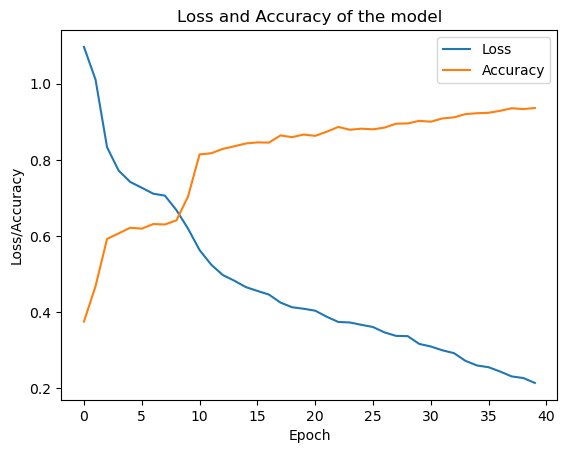

In [22]:
plt.figure()  
plt.plot(loss_history)
plt.plot(acc_history)
plt.title('Loss and Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(['Loss', 'Accuracy'])
plt.show()
